# COVID-19 Mortality Rate

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer
import optuna



import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/envs/mlproject/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set display options for better readability
pd.set_option("display.float_format", "{:.2f}".format)

In [3]:
#Extract and Load data from zip file
def load_data(zip_path:str) -> pd.DataFrame:
    """Extract and read COVID-19 data from a zip file."""

    # Load and Extract zip file
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall("data/")

    # Load data and parse date column
    data = pd.read_csv("data/owid-covid-data.csv", parse_dates=['date'])
    return data
    

In [4]:
zip_file = "data/archive.zip"
df = load_data(zip_file)
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-03,NaN,0.00,NaN,NaN,0.00,NaN,...,NaN,37.75,0.50,64.83,0.51,41128772.00,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-04,NaN,0.00,NaN,NaN,0.00,NaN,...,NaN,37.75,0.50,64.83,0.51,41128772.00,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-05,NaN,0.00,NaN,NaN,0.00,NaN,...,NaN,37.75,0.50,64.83,0.51,41128772.00,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-06,NaN,0.00,NaN,NaN,0.00,NaN,...,NaN,37.75,0.50,64.83,0.51,41128772.00,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-07,NaN,0.00,NaN,NaN,0.00,NaN,...,NaN,37.75,0.50,64.83,0.51,41128772.00,NaN,NaN,NaN,NaN


## Data Inspection and Data Cleaning

In [5]:
df.duplicated().sum()

np.int64(0)

In [6]:
df.isna().mean() * 100

iso_code                                   0.00
continent                                  4.75
location                                   0.00
date                                       0.00
total_cases                               10.83
                                           ... 
population                                 0.00
excess_mortality_cumulative_absolute      96.52
excess_mortality_cumulative               96.52
excess_mortality                          96.52
excess_mortality_cumulative_per_million   96.52
Length: 67, dtype: float64

In [7]:
df['date'].min(), df['date'].max()

(Timestamp('2020-01-01 00:00:00'), Timestamp('2023-10-19 00:00:00'))

### Observations
- Data contains no duplicates
- Data was collected from 1st of **JANUARY, 2020** to 19th of **OCTOBER, 2023**
- There is a very similar and low correlation strength between **median_age**, **aged_65_older** and **aged_70_older** with the **mortality_rate**, while knowning one of them is sufficient to predict the other

In [8]:
# Irrelevant columns to drop
cols = [
    "new_vaccinations_smoothed", 
    "new_vaccinations_smoothed_per_million",
    "new_people_vaccinated_smoothed", 
    "new_people_vaccinated_smoothed_per_hundred", 
    "total_cases_per_million",
    "new_cases_per_million", 
    "new_cases_smoothed_per_million",
    "total_deaths_per_million", 
    "new_deaths_per_million", 
    "new_deaths_smoothed_per_million",
    "new_cases_smoothed",
    "new_deaths_smoothed",
    "new_deaths",
    "new_cases"
]

In [9]:
def Clean_data(data: pd.DataFrame) -> pd.DataFrame:
    """Clean and preprocess the COVID-19 data."""

    df = data.copy()

    # Drop columns with more than 50% NaN values
    cols_to_drop = data.columns[(df.isna().mean() * 100) > 40.0].tolist()
    # Drop columns with High Cardinality
    cols_to_drop += ['iso_code', 'location']
    # More columns to drop based on their irrelevance 
    cols_to_drop += cols
    # drop 'aged_70_older' and 'Age_65_older' due to Multicollinearity
    cols_to_drop += ['aged_70_older', 'aged_65_older']
    data = data.drop(columns=cols_to_drop)



    # Drop rows with NaN in critical columns
    data.dropna(subset=['total_cases', 'total_deaths'], inplace=True)
    # Drop NaN for features with less than or approx 5% NaN values
    data.dropna(subset=['continent', 'life_expectancy', 'population_density', 'diabetes_prevalence',\
                         'median_age', 'gdp_per_capita',\
                        'cardiovasc_death_rate', 'human_development_index'], inplace=True)
    
    # impute filling NaN values
    data['hospital_beds_per_thousand'].fillna(data['hospital_beds_per_thousand'].median(), inplace=True)


    # Create outcome variable
    data["mortality_rate"] = (data['total_deaths'] / data['total_cases']) * 100
    data = data.reset_index(drop=True)


    return data

In [10]:
clean_df = Clean_data(df)
clean_df.head()

,continent,date,total_cases,total_deaths,population_density,median_age,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,human_development_index,population,mortality_rate
0,Asia,2020-03-24,40.00,1.00,54.42,18.60,1803.99,597.03,9.59,0.50,64.83,0.51,41128772.00,2.50
1,Asia,2020-03-25,42.00,1.00,54.42,18.60,1803.99,597.03,9.59,0.50,64.83,0.51,41128772.00,2.38
2,Asia,2020-03-26,74.00,1.00,54.42,18.60,1803.99,597.03,9.59,0.50,64.83,0.51,41128772.00,1.35
3,Asia,2020-03-27,74.00,1.00,54.42,18.60,1803.99,597.03,9.59,0.50,64.83,0.51,41128772.00,1.35
4,Asia,2020-03-28,80.00,2.00,54.42,18.60,1803.99,597.03,9.59,0.50,64.83,0.51,41128772.00,2.50


In [11]:
clean_df.shape

(222042, 14)

In [12]:
clean_df.isna().mean() * 100

continent                    0.00
date                         0.00
total_cases                  0.00
total_deaths                 0.00
population_density           0.00
median_age                   0.00
gdp_per_capita               0.00
cardiovasc_death_rate        0.00
diabetes_prevalence          0.00
hospital_beds_per_thousand   0.00
life_expectancy              0.00
human_development_index      0.00
population                   0.00
mortality_rate               0.00
dtype: float64

## Exploratory Data Analysis

In [13]:
num_cols = clean_df.select_dtypes('number').columns.tolist()
cat_cols = 'continent'

####  Visualize distributions of numerical features

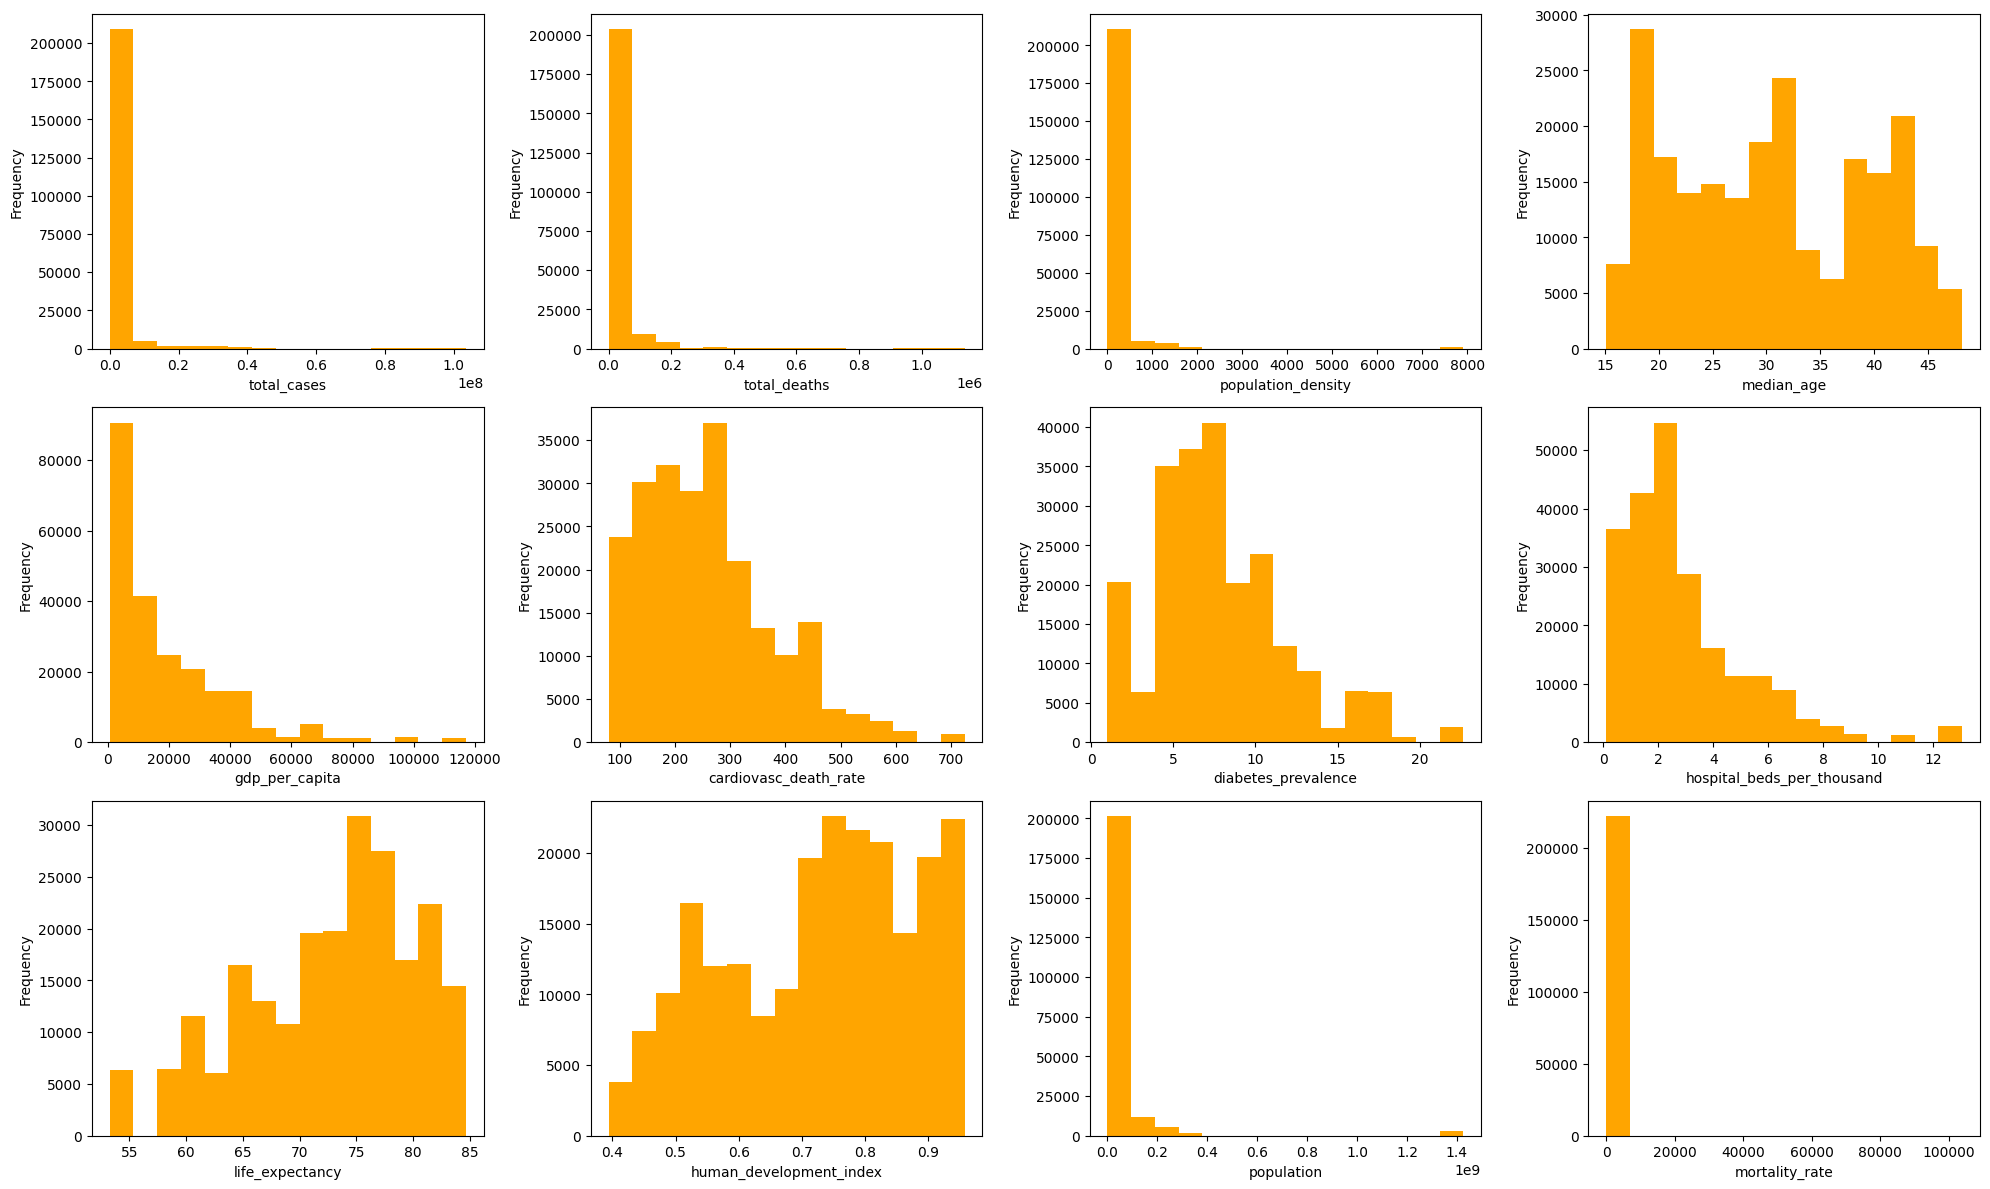

In [14]:
n_cols = 4
num_plots = len(num_cols)
n_rows = int(np.ceil(num_plots / n_cols))

# Create subplots
fig, ax = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
ax = ax.flatten()
for i, col in enumerate(num_cols):
    ax[i].hist(clean_df[col].dropna(), color="orange", bins=15)
    ax[i].set_xlabel(col)
    ax[i].set_ylabel("Frequency")

# Hide unused axes
for ax in ax[num_plots:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()   

In [15]:
# drop 'date' from num_cols if present
if 'date' in num_cols:
	num_cols.remove('date')

#### Check Correlation between Numeric Features

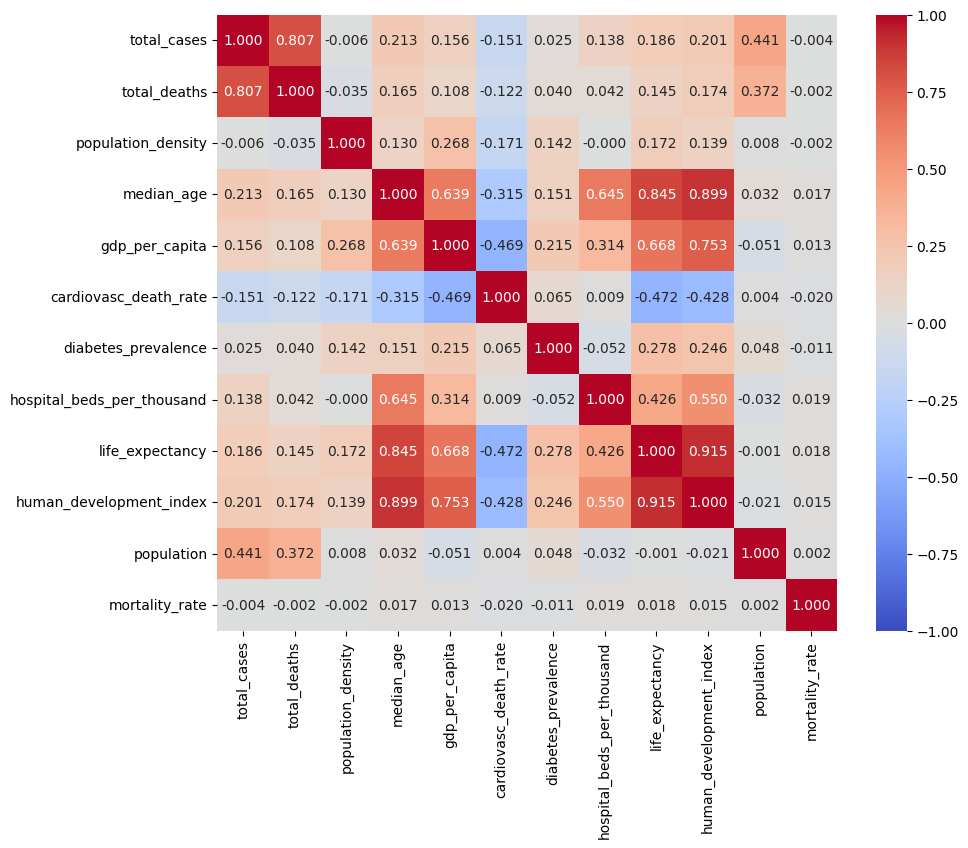

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(clean_df.select_dtypes('number').corr(), annot = True, vmax=1, vmin=-1, center=0, cmap='coolwarm', fmt=".3f");

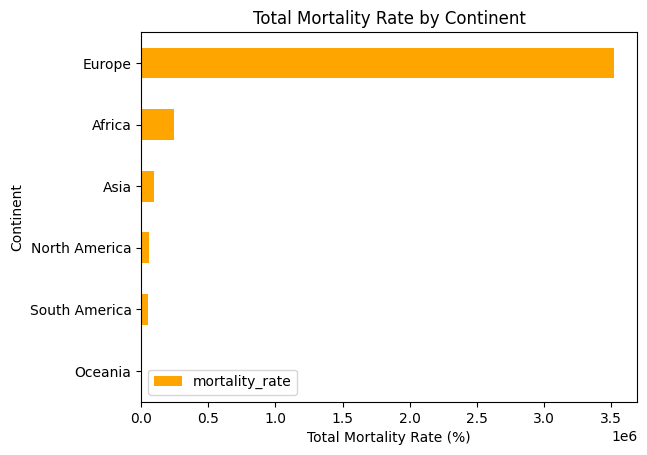

In [17]:
clean_df.groupby(['continent'])['mortality_rate',].sum().sort_values(['mortality_rate']).plot(kind='barh', color = 'orange')
plt.xlabel('Total Mortality Rate (%)')
plt.ylabel('Continent')
plt.title('Total Mortality Rate by Continent');

right Skewed features
- pop density
- gdp per capital
- cardiovascular death rate
- diabetes prevalence
- hospital beds_per_thousand
- pop
- label


left
- life expectancy
- human dev rate

In [18]:
clean_df.shape

(222042, 14)

## Data Preprocessing

#### Split data

In [19]:
LABEL = 'mortality_rate'
X = clean_df.drop(columns = [LABEL, 'date'], axis = 1)
y = clean_df[LABEL]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=42)

In [21]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(155429, 12)
(155429,)
(66613, 12)
(66613,)


In [22]:
y_train.head()

51530    1.68
52426    1.42
78555    2.52
193671   1.41
192097   1.62
Name: mortality_rate, dtype: float64

In [23]:
num_features = ['total_cases', 'total_deaths', 'population_density',
       'median_age', 'gdp_per_capita', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'population']
cat_features = ['continent']

In [24]:
pt = PowerTransformer(method = 'box-cox', standardize= False)

In [25]:
# for col in X_train.select_dtypes('number').columns:
#     X_train[col], l = boxcox(X_train[col])
#     print(f"{col}: {l}")
#     print("------------")

In [26]:
X_train.head()

,continent,total_cases,total_deaths,population_density,median_age,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,human_development_index,population
51530,Europe,18447.00,309.00,73.73,44.00,22669.80,253.78,5.59,5.54,78.49,0.85,4030361.00
52426,Europe,1270075.00,18025.00,73.73,44.00,22669.80,253.78,5.59,5.54,78.49,0.85,4030361.00
78555,Europe,3677841.00,92549.00,237.02,46.60,45229.25,156.14,8.31,8.00,81.33,0.95,83369840.00
193671,Europe,1012742.00,14278.00,24.72,41.00,46949.28,133.98,4.79,2.22,82.80,0.94,10549349.00
192097,South America,3460.00,56.00,3.61,29.60,13767.12,258.31,12.54,3.10,71.68,0.74,618046.00


In [27]:
X_train_copy = X_train.copy()

In [28]:
# Remove 'continent' from the copied data, transform numeric features, then add 'continent' back
X_num = X_train_copy.drop(columns= cat_features)
X_num_transformed = pt.fit_transform(X_num)
X_transformed = pd.DataFrame(X_num_transformed, columns=X_num.columns, index=X_num.index)
X_transformed = X_transformed.assign(continent=X_train_copy[cat_features])

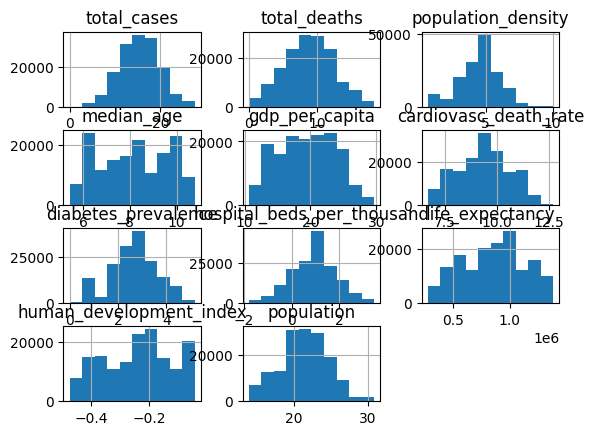

In [29]:
X_transformed.hist();

### Further EDA

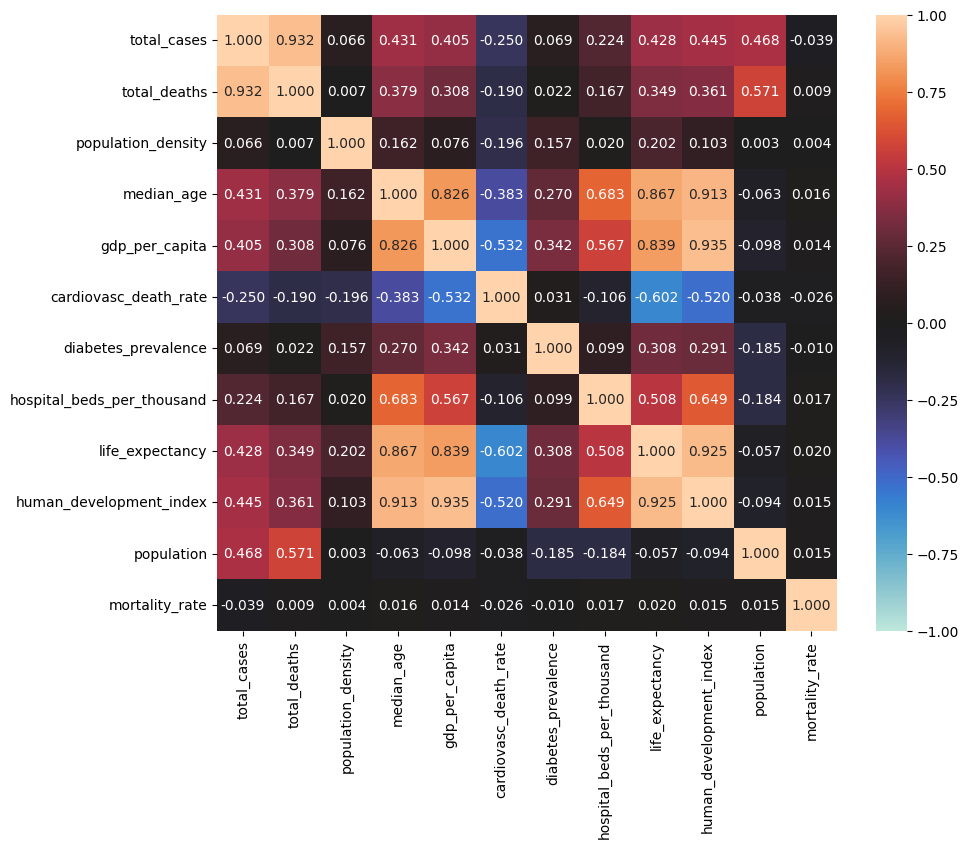

In [37]:
plt.figure(figsize=(10, 8))
corr = X_transformed.select_dtypes('number').assign(mortality_rate=y_train)
sns.heatmap(corr.corr(), annot = True, vmax=1, vmin=-1, center=0, fmt=".3f");

In [30]:

# Numerical pipeline: PowerTransformer + StandardScaler
num_pipeline = Pipeline([
    ("power", PowerTransformer()),
    ("scaler", StandardScaler())
])

# Categorical pipeline: Label Encoding (use OrdinalEncoder inside CT)
cat_pipeline = Pipeline([
    ("ordinal", OrdinalEncoder())
])

In [31]:
# Combine with ColumnTransformer
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

## Model Selection

In [32]:
# Models
models = {
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    # "XGBoost": xgb.XGBRegressor(random_state=42, verbosity=0)
}



In [ ]:
results = {}
for name, model in models.items():
    pipe = Pipeline([
        ("preprocess", preprocessor),
        ("model", model)
    ])
    kf = KFold(n_splits=2, shuffle=True, random_state=42)
    scores = -cross_val_score(pipe, X_train, y_train, cv= kf, scoring="neg_mean_squared_error")
    results[name] = scores

print("CV Results:", results)

CV Results: {'RandomForest': array([2600.26329727, 3524.34822468]), 'GradientBoosting': array([16.9542393 , 43.53776377])}


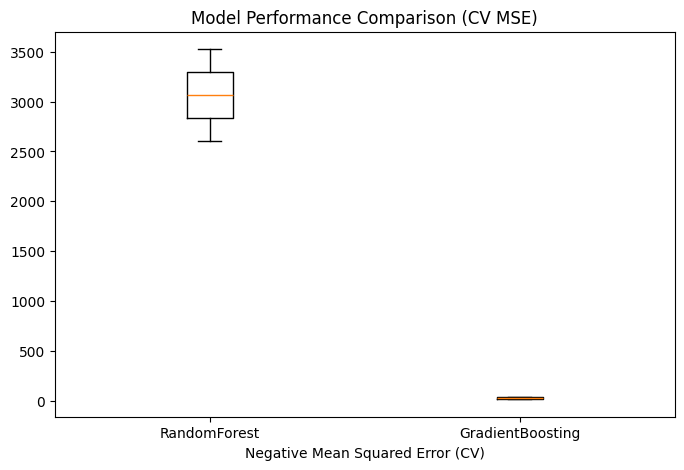

In [38]:
plt.figure(figsize=(8, 5))
plt.boxplot([results[name] for name in results.keys()], labels=list(results.keys()))
plt.xlabel("Negative Mean Squared Error (CV)")
plt.title("Model Performance Comparison (CV MSE)")
plt.show()

In [40]:
# Pick best model
best_model_name = min(results, key=lambda k: results[k].mean())
print("Best Model:", best_model_name)

Best Model: GradientBoosting


In [ ]:
# Define the objective function
def objective(trial):
    # Define hyperparameters to search
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "random_state": 42,
        "n_jobs": -1,
        "use_label_encoder": False,
        "eval_metric": "logloss"
    }
    
    # Build model
    model = XGBClassifier(**params)
    
    # Cross-validation
    score = cross_val_score(model, X, y, cv=5, scoring="roc_auc").mean()
    
    return score

# Create study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best params:", study.best_params)
print("Best score:", study.best_value)

# Train final model on full data
best_model = XGBClassifier(**study.best_params)
best_model.fit(X, y)
